In [472]:
import sys 
sys.path.append('scripts')
from TuneClass import *
import TuneClass
#import Executable
import Envelope
#from Executable import Tune
#from Executable import main
import imp
#imp.reload(dbreader)
#imp.reload(Executable)
imp.reload(TuneClass)
imp.reload(Envelope)
import matplotlib.pyplot as plt
import re
plt.rcParams['font.family'] = 'Times New Roman'


In [187]:
import fcwt
from pydub import AudioSegment
import scipy.io.wavfile as wav  

In [418]:
class Tune:
    def __init__(self, X=None, T=None, R=None, M=None, L=None, key=None, abc=""):
        self.X = X  # Reference number
        self.T = T  # Title
        self.R = R  # Rhythm type
        self.M = M  # Meter
        self.L = L  # Default note length
        self.K = key  # Key signature
        self.abc = abc  # Full ABC notation
        self.notes = []  # Placeholder for extracted notes

    def extract_notes(self):
        """ Extracts the note sequence from ABC notation. """
        self.notes = abc_to_notestring(self.abc)
        self.notes = keychanger(self,self.key)
        self.tones = notes_to_semitones2(self,universal_encoder)  # Update after ABC is fully set
        self.waveform = np.float32(constructor(self,'piano',.15))
    def __str__(self):
        return f"X: {self.X}, T: {self.T}, R: {self.R}, M: {self.M}, L: {self.L}, K: {self.K}, Notes: {self.notes[:50]}..."

    def play(self,duration = .125,instrument='piano'):
        waveform = constructor(self,instrument,duration)
        waveform = np.float32(waveform)
        sd.play(waveform,samplerate=8000)
        sd.wait()

# Read the file and parse entries
tunes = []
with open("reels.txt", "r", encoding="utf-8") as file:
    current_tune = None  # Holds the current tune being parsed

    for line in file:
        line = line.strip()  # Remove leading/trailing whitespace
        
        if not line:  # Empty line indicates a new tune might be starting
            if current_tune:  # If there's an active tune, store it
                tunes.append(current_tune)
            current_tune = None  # Reset for the next tune
            continue

        if line.startswith("X:"):  # Start of a new tune
            if current_tune:  # Store the previous tune before starting a new one
                tunes.append(current_tune)
            current_tune = Tune(X=line[2:].strip())  # Create new tune instance
        elif line.startswith("T:") and current_tune:
            current_tune.T = line[2:].strip()
        elif line.startswith("R:") and current_tune:
            current_tune.R = line[2:].strip()
        elif line.startswith("M:") and current_tune:
            current_tune.M = line[2:].strip()
        elif line.startswith("L:") and current_tune:
            current_tune.L = line[2:].strip()
        elif line.startswith("K:") and current_tune:
            current_tune.key = line[2:].strip()
        elif current_tune and not re.match(r"^[SCZ]:", line):  # All other lines are part of the ABC notation
            current_tune.abc += line + "\n"

    # Append the last parsed tune (if any)
    if current_tune:
        current_tune.extract_notes()
        tunes.append(current_tune)
for i in tunes:
    i.extract_notes()


In [25]:
# image editing
import cv2
import numpy as np

def reduce_resolution(image, new_shape):
    # Compute magnitude and phase
    magnitude = np.abs(image)
    phase = np.angle(image)
    
    # Resize using OpenCV
    magnitude_resized = cv2.resize(magnitude, new_shape, interpolation=cv2.INTER_AREA)  # Best for downscaling
    phase_resized = cv2.resize(phase, new_shape, interpolation=cv2.INTER_LINEAR)  # Phase needs smooth interpolation
    
    # Reconstruct the complex image
    resized_image = magnitude_resized * np.exp(1j * phase_resized)
    
    return resized_image

def increase_contrast_complex(image, alpha=2.0, beta=0):
    """
    Increase the contrast of a complex image array.
    
    Parameters:
    - image: Complex numpy array (with real and imaginary parts)
    - alpha: Contrast control (1.0 means no change, >1.0 increases contrast)
    - beta: Brightness control (0 means no change)
    
    Returns:
    - contrasted_image: The complex image with enhanced contrast
    """
    # Separate magnitude and phase
    magnitude = np.abs(image)
    phase = np.angle(image)
    
    # Apply contrast enhancement to magnitude
    magnitude_contrasted = np.clip(alpha * magnitude + beta, 0, 1)
    
    # Reconstruct the complex image with the enhanced magnitude
    contrasted_image = magnitude_contrasted * np.exp(1j * phase)
    
    return contrasted_image

In [432]:
# transform, wavelet coherence, transform plot
import numpy as np
from pycwt import wct
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve1d,zoom
import scipy.io.wavfile as wav
from PIL import Image, ImageEnhance
# Compute the wavelet coherence
def gamma_correction_complex(image, gamma=.35,clip_point = .5):
    # Compute magnitude and phase    
    magnitude = np.abs(image)
    phase = np.angle(image)
    magnitude_max = np.max(magnitude)
    if magnitude_max > 0:
        magnitude = magnitude / magnitude_max  # Normalize to [0,1]
    magnitude = np.clip(magnitude*4,clip_point,1)
    # Apply gamma correction to the magnitude
    magnitude_corrected = np.power(magnitude, gamma)
    blur_strength = 2
    blur_kernel = np.ones(blur_strength) / blur_strength  # 1D blur kernel
    magnitude_corrected = convolve1d(magnitude_corrected, blur_kernel, axis=1, mode='reflect')

    # Reconstruct the complex image
    corrected_image = magnitude_corrected * np.exp(1j * phase)
    return corrected_image

def transform(signal1,frame_rate,clip_point,correction= True):
    highest = 5000
    lowest = 200
    nfreqs = 300
    freqs, coeffs1 = fcwt.cwt(signal1,frame_rate,lowest,highest,nfreqs,nthreads = 4,scaling='log')
    coeffs1 = reduce_resolution(coeffs1, (800, 300))
    if correction:
        coeffs1 = gamma_correction_complex(coeffs1,clip_point = clip_point)
    return coeffs1,freqs

def transform_plot(signal,frame_rate,clip_point,correction = True):

    coeffs1,freqs = transform(signal,frame_rate,clip_point,correction)

    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    extent=[0, len(signal)/frame_rate, len(freqs),0]

    plt.figure(figsize=(10, 5))
    plt.imshow(np.abs(coeffs1), aspect='auto', extent=extent, cmap='jet')
    plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values])

    plt.colorbar(label='Magnitude')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Wavelet Transform Magnitude')
    plt.show()
    return coeffs1,freqs

def wavelet_coherence(coeffs1,coeffs2,frame_rate,freqs):

    # Compute coherence
    S1 = np.abs(coeffs1) ** 2
    S2 = np.abs(coeffs2) ** 2
    S12 = coeffs1 * np.conj(coeffs2)
    
    # Smooth spectra and cross-spectrum
    def smooth(data, sigma=(2,2), mode='nearest'):
        return data
        #ensure only horizontal smoothing
        return gaussian_filter(data, sigma=sigma, mode=mode)

    S1_smoothed = smooth(S1)
    S2_smoothed = smooth(S2)
    S12_smoothed = smooth(np.abs(S12) ** 2)

    # Coherence calculation
    #coherence = S12_smoothed / (((S1_smoothed) **2) * ((S2_smoothed)**2))
    coherence = S12_smoothed / (np.sqrt(S1_smoothed) * np.sqrt(S2_smoothed))

    return coherence, freqs 




In [225]:
def match_signal_length(signal1, signal2, pad_value=0):
    """
    Adjusts signal2 to match the length of signal1 by either padding or trimming.
    
    Parameters:
    - signal1 (numpy array): The reference signal.
    - signal2 (numpy array): The signal to adjust.
    - pad_value (int or float, optional): The value to use for padding. Default is 0.
    
    Returns:
    - numpy array: signal2, modified to match the length of signal1.
    """
    len1 = len(signal1)
    len2 = len(signal2)
    
    if len2 > len1:
        # Trim signal2 if it's longer
        return signal2[:len1]
    elif len2 < len1:
        # Pad signal2 if it's shorter
        padding = np.full((len1 - len2,), pad_value)  # Create padding array
        return np.concatenate((signal2, padding))
    else:
        # Already the same length
        return signal2


In [226]:
def coherence_signals(tune,recording,frame_rate,plot=True):
    
    audio_data1 = np.array(recording, dtype=np.float32)
    audio_data1 -= np.mean(audio_data1)
    # 2. Divide by the maximum absolute value to scale between -1 and 1
    max1 = np.max(np.abs(audio_data1))
    if max1 > 0:
        data1 = audio_data1 / max1
    data2 = tune.waveform
    audio_data2 = np.array(data2, dtype=np.float32)
    audio_data2 -= np.mean(audio_data2)
    # 2. Divide by the maximum absolute value to scale between -1 and 1
    max2 = np.max(np.abs(audio_data2))
    if max2 > 0:
        data2 = audio_data2 / max2
        
    data2 = match_signal_length(data1, data2)
    coeffs1,freqs = transform(data1,frame_rate)
    coeffs2,_ = transform(data2,frame_rate)
    coherence, freqs = wavelet_coherence(coeffs1,coeffs2, frame_rate,freqs)
    extent=[0, len(data1)/frame_rate, len(freqs),0]

    coherence = np.clip(coherence,.7,None)
    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    if plot:
        plt.figure(figsize=(10, 6))
        plt.imshow(coherence, aspect='auto', extent=extent,cmap = 'jet')
        plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values])
        plt.xticks(np.linspace(0, len(data1)/frame_rate, 5))
        plt.colorbar(label='Coherence')
        plt.ylabel('Scale (Frequency)')
        plt.xlabel('Time (seconds)')
        plt.title(f'Wavelet Coherence: {tune.T}')
        plt.show()
    return coeffs1,coeffs2,freqs,coherence


In [227]:
frame_rate = 8000
def create_transforms(tunes):
    for i in tunes:
        audio_data1 = np.array(i.waveform, dtype=np.float32)
        audio_data1 -= np.mean(audio_data1)
        # 2. Divide by the maximum absolute value to scale between -1 and 1
        max1 = np.max(np.abs(audio_data1))
        if max1 > 0:
            data1 = audio_data1 / max1
        i.transform = transform(data1,frame_rate,clip_point = .3)

In [228]:
# coherence plot
from IPython.display import display
def coherence_plot(tune,recording_transform,frame_rate,plot=True): 
    # should be able to take in a tune object and a recording object and
    # efficiently compute the coherence between the two waveforms. without having 
    # to recompute the wavelet transform for the tune object
    coeffs1 = tune.transform[0]
    coeffs2 = recording_transform
    freqs = tune.transform[1]
    coherence, freqs = wavelet_coherence(coeffs1,coeffs2, frame_rate,freqs)
    extent=[0, len(tune.waveform)/frame_rate, len(freqs),0]

    coherence = np.where(coherence<.1,0,coherence)
    max1 = np.max(np.abs(coherence))
    min1 = np.min(np.abs(coherence))
    coherence = (coherence-min1) / (max1-min1)
    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    plt_obj = None
    if plot:
        plt.figure(figsize=(10, 6))
        plt.imshow(coherence, aspect='auto', extent=extent,cmap = 'jet')
        plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values])
        plt.xticks(np.linspace(0, len(tune.waveform)/frame_rate, 5))
        plt.colorbar(label='Coherence')
        plt.ylabel('Scale (Frequency)')
        plt.xlabel('Time (seconds)')
        plt.title(f'Wavelet Coherence: {tune.T}')
        plt_obj = plt.gcf()
        plt.close()

        
    return coeffs1,coeffs2,freqs,coherence,plt_obj


In [229]:
def align_using_cross_correlation(ref_signal, target_signal, sr):
    """
    Aligns target_signal to ref_signal using cross-correlation.
    
    Parameters:
        ref_signal (numpy array): The reference audio signal.
        target_signal (numpy array): The misaligned audio signal.
        sr (int): Sample rate of the audio.
        
    Returns:
        numpy array: The aligned target signal.
    """
    # Compute cross-correlation
    corr = np.correlate(target_signal, ref_signal, mode="full")
    lag = np.argmax(corr) - len(ref_signal) + 1  # Find the best shift

    # Apply time shift (trim or pad)
    if lag > 0:
        aligned_target = target_signal[lag:]  # Cut off leading part
    else:
        aligned_target = np.pad(target_signal, (abs(lag), 0), mode="constant")  # Pad with zeros

    return aligned_target

In [230]:
# m4a to reel, trim silence
AudioSegment.converter = "C:/Users/24261951/Documents/Projects/ffmpeg-master-latest-win64-gpl/bin/ffmpeg.exe"                  
from pydub import utils, AudioSegment

def get_prober_name():
    return "C:/Users/24261951/Documents/Projects/ffmpeg-master-latest-win64-gpl/bin/ffprobe.exe"
utils.get_prober_name = get_prober_name

def trim_silence(signal, threshold):
    """
    Removes all values before the signal first exceeds the threshold.
    
    Parameters:
    signal (numpy array): The input signal
    threshold (float): The minimum amplitude to start keeping values
    
    Returns:
    numpy array: Trimmed signal starting from the first peak above the threshold
    """
    # Find the first index where the signal exceeds the threshold
    index = np.argmax(np.abs(signal) >= threshold)
    
    # Slice the signal from that index onwards
    return signal[index:] if np.abs(signal[index]) >= threshold else np.array([])


In [231]:
# m4a to reel, wav to reel
def m4a_to_reel(file):
    audio = AudioSegment.from_file(file,format='m4a')
    audio = audio.set_frame_rate(8000)
    if audio.channels == 2:
        samples = samples.reshape((-1, 2)).mean(axis=1)
    audio = np.frombuffer(audio.raw_data,np.int16)
    audio = (audio)/max(abs(audio))
    audio = trim_silence(audio,0.5) # begin when playing starts
    audio = match_signal_length(tunes[0].waveform,audio)
    #audio = align_using_cross_correlation(tunes[1].waveform,audio,8000)
    return audio

def wav_to_reel(file):
    audio = AudioSegment.from_file(file,format='wav')
    audio = audio.set_frame_rate(8000)
    if audio.channels == 2:
        audio = audio.set_channels(1)
    audio = np.frombuffer(audio.raw_data,np.int16)
    audio = (audio)/max(abs(audio))
    audio = trim_silence(audio,0.5) # begin when playing starts
    audio = match_signal_length(tunes[0].waveform,audio)
    #audio = align_using_cross_correlation(tunes[1].waveform,audio,8000)
    return audio

def wav_to_data(file,set_fr = False):
    audio = AudioSegment.from_file(file,format='wav')
    if set_fr:
        audio = audio.set_frame_rate(8000)
    if audio.channels == 2:
        audio = audio.set_channels(1)
    audio = np.frombuffer(audio.raw_data,np.int16)
    audio = (audio)/max(abs(audio))
    audio = trim_silence(audio,0.5) # begin when playing starts
    #audio = align_using_cross_correlation(tunes[1].waveform,audio,8000)
    return audio

In [490]:
# subplots from png
from PIL import Image
import os
import matplotlib.pyplot as plt

def create_subplots_from_png(directory,top_keys):
    # Get list of all .png files in the directory
    png_files = [f for f in os.listdir(directory) if f.endswith('.png')]
    # Determine the number of rows and columns for the subplots
    num_files = len(png_files)
    cols = 1  # Number of columns in the subplot grid
    rows = 5# (num_files // cols) + (num_files % cols > 0)  # Calculate rows needed

    # Create a figure and axes for the subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15,15))
    axes = axes.flatten()  # Flatten the axes array for  easy iteration

    for ax, png_file in zip(axes, png_files):
        img = Image.open(os.path.join(directory, png_file))
        ax.imshow(img)
        ax.set_title(png_file[:-4])
        ax.axis('off')  # Hide the axes

    # Hide any remaining empty subplots
    for ax in axes[num_files:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [487]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_sums(sums):
    # Extract keys and values from the sums dictionary
    keys = list(sums.keys())
    values = np.array(list(sums.values()))  # Convert values to a NumPy array
    values = values - min(values)  # Normalize to start from 0
    
    # Create a DataFrame for easier plotting with Seaborn
    data = pd.DataFrame({'Tune': keys, 'Total Coherence': values})
    
    # Create a horizontal bar plot with Seaborn
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Total Coherence', y='Tune', data=data,color = 'navy', orient='h')
    plt.xlabel('Total Coherence')
    plt.ylabel('Tune')
    plt.xticks(fontsize=10)

    plt.title('Summed Coherence for Each Tune')
    plt.tight_layout()
    plt.show()

In [488]:
# workflow
import os
import shutil
def workflow(recording,frame_rate = 8000,plot = False,save = False,title = 'unspecified title',clip_point = .1):
    file = f'recordings/{recording}'
    if file[-3:] == ('m4a'):
        tune = m4a_to_reel(file)
    elif file[-3:] == ('wav'):
        tune = wav_to_reel(file)
    elif type(recording) == np.ndarray or type(file) == list:
        tune = recording
        recording = title
    else:
        return "Unsupported input format"
    sums = {}
    tform = transform(tune,frame_rate,clip_point = clip_point)
    
    output_dir = f'coherence_results/{recording}'
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)  # Remove only if it exists
    os.makedirs(output_dir)
    # Calculate the required number of rows
    plts = {}
    for n,i in enumerate(tunes):
        _,_,_,coh,plt_obj = coherence_plot(i,tform[0],frame_rate,plot=True)
        plts[i.T] = plt_obj
   
        sums[i.T] = np.where(coh<.5,0,coh).sum()

    top_keys = sorted(sums, key=sums.get, reverse=True)[:5]

    
    if plot:
        for i in plts:
            if i in top_keys:
                value = plts[i]
                value.savefig(f'coherence_results/{recording}/{i}.png')

    if plot:
        if os.path.exists(f'coherence_results/{recording}'):
            create_subplots_from_png(f'coherence_results/{recording}/',top_keys)
    if not save:
        shutil.rmtree(f'coherence_results/{recording}')
    min_value = min(sums.values())
    top_keys = sorted(sums, key=sums.get, reverse=True)[:5]
    print(f'Top Guesses: {top_keys}')
    # Divide all values by the minimum
    normalized_sums = {key: value - min_value + 5 for key, value in sums.items()}   
    keys = list(normalized_sums.keys())
    values = list(normalized_sums.values())
    if plot:
        plot_sums(normalized_sums)
    
    return sums

In [459]:
#metronome thread
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wav
import time
import threading

def generate_click(samplerate=44100):
    """Generates a short, percussive click sound."""
    duration = 0.1  # 10ms for sharp click
    samples = int(samplerate * duration)

    # White noise burst
    noise = np.random.uniform(-1.0, 1.0, samples) * 0.5  

    # Apply an envelope for fast decay
    envelope = np.linspace(1, 0, samples)  # Fast fade-out
    click_sound = noise * envelope

    return click_sound.astype(np.float32), duration  # Return both sound & duration

def generate_tone(frequency=1000, duration=0.1, samplerate=44100):
    """Generates a beep sound for count-in."""
    t = np.linspace(0, duration, int(samplerate * duration), endpoint=False)
    tone = 0.5 * np.sin(2 * np.pi * frequency * t)
    return tone.astype(np.float32), duration  # Return both sound & duration

def metronome_thread(bpm, num_clicks,count_in):
    """Plays a count-in (8 beeps) followed by exactly `num_clicks` metronome clicks."""
    global recording_active
    beat_interval = 60.0 / bpm  # Exact time per beat (seconds)

    beep_sound, beep_duration = generate_tone(frequency=1000, duration=0.1)  # Count-in sound
    click_sound, click_duration = generate_click()  # Sharp click

    with sd.OutputStream(samplerate=44100, channels=1) as stream:
        start_time = time.monotonic()  # Start timing reference

        # Count-in (8 beeps)
        for _ in range(count_in):
            if not recording_active:
                return
            stream.write(beep_sound)
            next_beat_time = start_time + (_ + 1) * beat_interval
            time.sleep(max(0, next_beat_time - time.monotonic()))  # Sync precisely

        # Play exactly `num_clicks` metronome clicks
        for i in range(num_clicks):
            if not recording_active:
                return
            stream.write(click_sound)
            next_beat_time = start_time + (i + 9) * beat_interval  # Continue timing after count-in
            time.sleep(max(0, next_beat_time - time.monotonic()))  # Sync precisely

def record_audio_with_metronome(bpm, num_clicks, samplerate,count_in):
    """Records audio while playing exactly `num_clicks` metronome clicks after a count-in."""
    global recording_active
    recording_active = True

    # Calculate recording duration (8 count-in beeps + num_clicks clicks)
    duration = ((num_clicks + count_in) * 60) / bpm  

    print(f"Recording for {duration:.2f} seconds with metronome at {bpm} BPM...")

    # Start the metronome in a separate thread
    metronome_threading = threading.Thread(target=metronome_thread, args=(bpm, num_clicks,count_in))
    metronome_threading.start()
    
    time.sleep(0.1)  # Ensures metronome starts before recording

    # Start recording
    audio_data = sd.rec(int(duration * samplerate), samplerate=samplerate, channels=2, dtype=np.int16)
    sd.wait()  # Ensure the recording completes
    audio_data = np.mean(audio_data, axis=1, dtype=np.int16)

    recording_active = False  # Stop metronome after recording
    metronome_threading.join()

    # Save the recording
    return audio_data
    print(f"Recording saved as {filename}")

# Example usage
#bpm = 200
#num_clicks = 65 # Play exactly 64 clicks
#count_in = 9
#record_audio_with_metronome("metronome_record2.wav", bpm=bpm, num_clicks=num_clicks,count_in=count_in,samplerate=44100)


In [460]:
import pickle

# Save the `tunes` object to a file
with open('tunes.pkl', 'wb') as file:
    pickle.dump(tunes, file)

print("Tunes object saved successfully")

Tunes object saved successfully


In [461]:
import pickle

# Load the `tunes` object from the file
with open('tunes.pkl', 'rb') as file:
    tunes = pickle.load(file)

print("tunes object loaded successfully")

tunes object loaded successfully


In [463]:
def record(frame_rate = 8000,bpm = 200,num_clicks = 65,count_in = 9,save = False,plot = False):
    audio_data1 = record_audio_with_metronome(bpm = bpm,
                                             num_clicks = num_clicks,
                                             samplerate=frame_rate,
                                             count_in = count_in)
    
    # capture the corresponding segment of the tune
    factor = frame_rate/8000
    window_size = 154800 *factor  # Fixed window size
    end_sample = int(factor*(-1 - 81)) # End of the window moves left each iteration - optimal
    start_sample = int(factor*(end_sample - window_size + 1))  # Ensure the window remains 154800 samples

    # Slice the audio data
    audio_data = audio_data1[start_sample:end_sample + 1]  # +1 to include `end_sample`
    filepath = 'unspecified title'
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(audio_data)
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.title('Recorded Audio')
        plt.show()

        transform_plot(audio_data,frame_rate,clip_point = .05)
    if save:
        inp = input('Save recording? (y/n): ')
        if inp.lower() == 'y':    
            filepath = input('YourName Intstrument TuneTitle')
            wav.write('recordings/'+filepath+'.wav',frame_rate,audio_data1)
            
            # Specify the name of the directory to be created
            directory = 'coherence_results/'+filepath

            # Check if the directory already exists
            if os.path.exists(directory):
                response = input(f"Results for '{directory}' already exists. Do you want to overwrite it? (y/n): ")
                if response.lower() == 'y':
                    shutil.rmtree(directory)  # Remove the existing directory
                    os.makedirs(directory)  # Create a new directory
                    print(f"Directory '{directory}' overwritten successfully")
                else:
                    print("Operation cancelled")
            else:
                os.makedirs(directory)
                print(f"Directory '{directory}' created successfully")
            wav.write('coherence_results/'+filepath+'/raw_audio.wav',frame_rate,audio_data1)
        else:
            return "no more like robin hood", "shall he roam through cricklewood"
    sums = workflow(audio_data,frame_rate,plot = plot,save=save,title=filepath)
  
    return sums,audio_data

Recording for 22.20 seconds with metronome at 200 BPM...


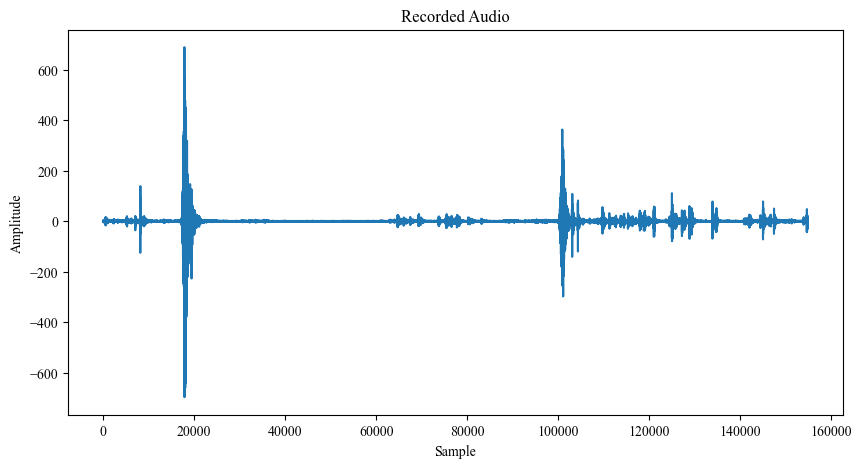

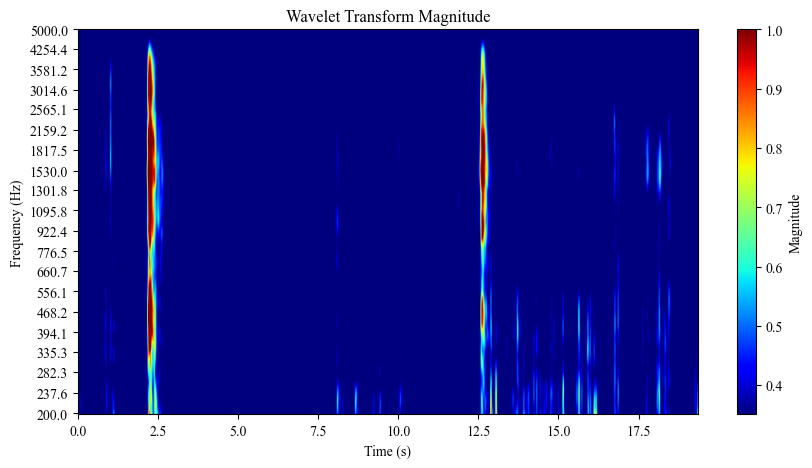

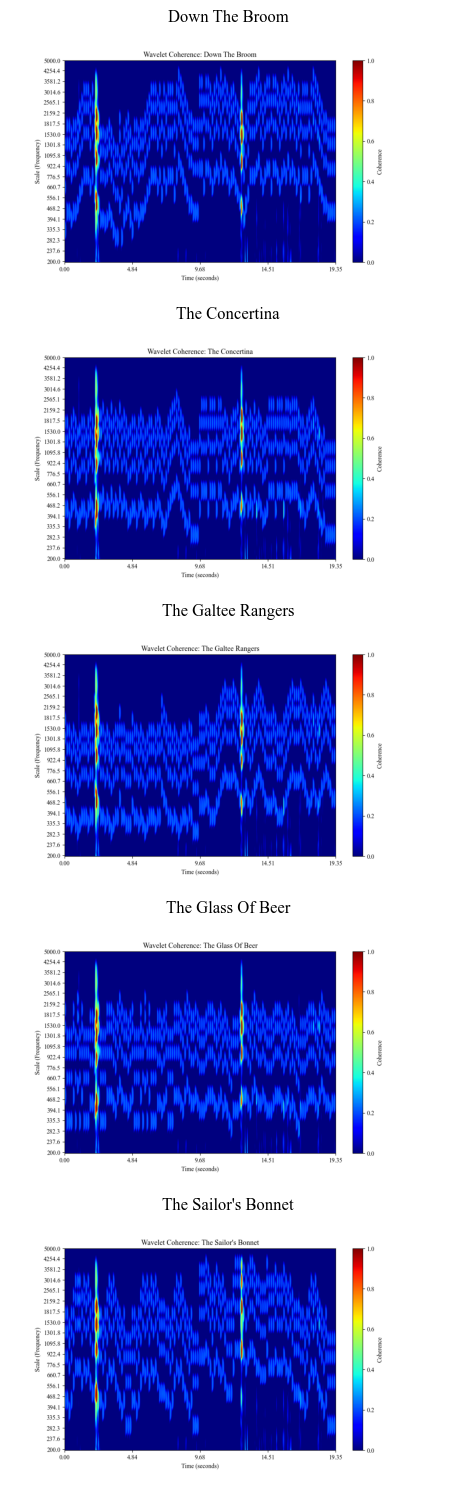

Top Guesses: ['The Galtee Rangers', 'The Glass Of Beer', 'Down The Broom', "The Sailor's Bonnet", 'The Concertina']


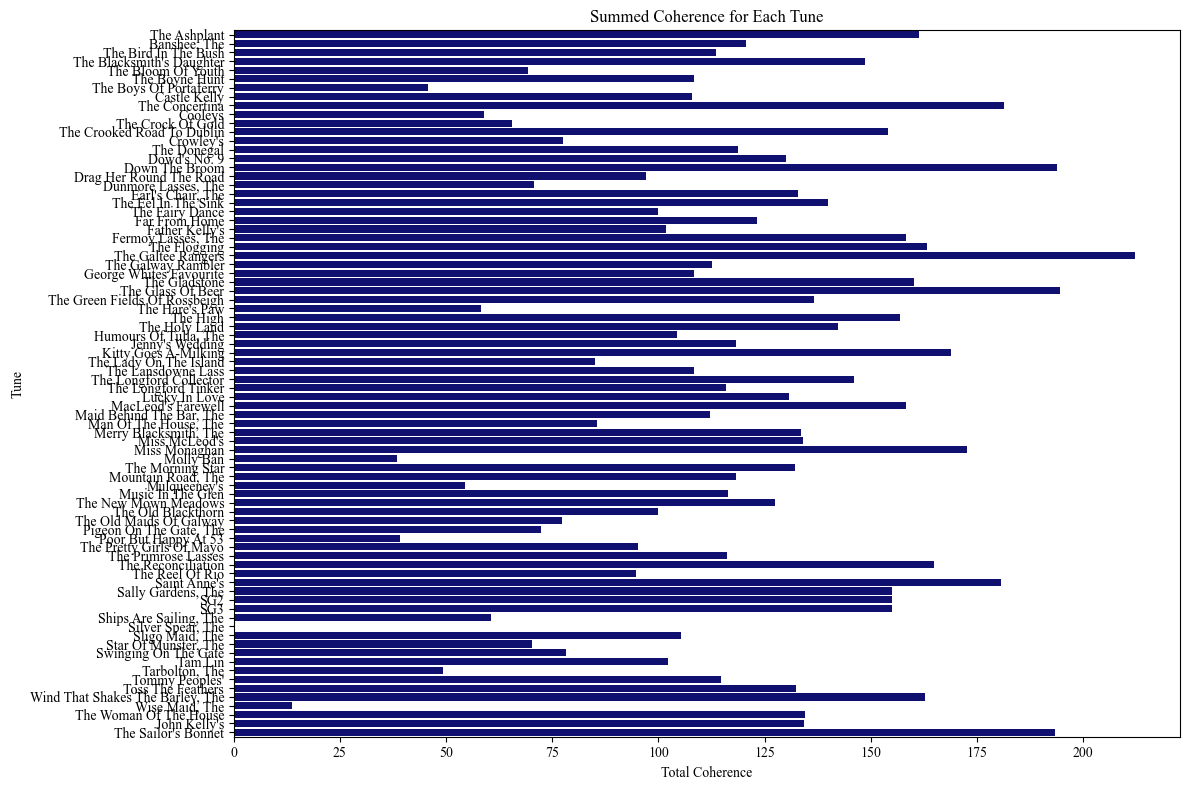

In [489]:
sums,audio_data = record(plot = True)

In [112]:
import numpy as np

def opt(audio_data1, var, frame_rate=8000, bpm=200, num_clicks=65, count_in=9, save=False, plot=False):
    window_size = 154800  # Fixed window size
    end_sample = -1 - var  # End of the window moves left each iteration
    start_sample = end_sample - window_size + 1  # Ensure the window remains 154800 samples

    # Slice the audio data
    audio_data = audio_data1[start_sample:end_sample + 1]  # +1 to include `end_sample`

    if len(audio_data) != window_size:
        raise ValueError(f"Invalid slice at iteration {var}: start={start_sample}, end={end_sample}, length={len(audio_data)}")

    # Process with `work`
    filepath = 'unspecified title'
    sums = work(audio_data, frame_rate, plot=plot, save=save, title=filepath)

    return audio_data, sums



sult = []
for i in range(75,85):
    audio_data, sums = opt(x, i)

    if 'Banshee, The' in sums:
        sult.append((sums['Banshee, The'],i))
        print(sult[-1])
    else:
        print(f"'Banshee, The' not found in iteration {i}")


(3009.8928, 75)
(3013.052, 76)
(3023.2368, 77)
(3031.5376, 78)
(3040.7617, 79)
(3049.057, 80)
(3050.0847, 81)
(3036.467, 82)
(3022.9163, 83)
(3011.1523, 84)
